<html>
    <body>
    <h1 style="color:#483D8B;text-align:center;">scRNA-Seq - Foetal Project</h1> 
    <h2 style="color:#483D8B;text-align:center;">Statistical Analysis Number of Expressed Genes - Femur vs Liver</h2>
    <br>17 April 2020 @ Sanger WTSI
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    <h3 style="color:#483D8B;">Andrea Tangherloni, PhD</h3><br>
    Research Associate – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at860@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:at19@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">   
    <h3 style="color:#483D8B;">Simone G. Riva, MSc</h3><br>
    PhD student – University of Cambridge<br>
    <b> Cvejic Group </b><br>
    School of Clinical Medicine – Department of Haematology<br>
    Wellcome Trust – Medical Research Council<br>
    Cambridge Stem Cell Institute – Sanger<br>
    <br>
    <em>
        <span style="color:#483D8B;"><b>Address:</b></span> Wellcome Genome Campus,<br>
        Hinxton, Cambridge, CB10 1HH<br>
        United Kingdom<br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sgr34@cam.ac.uk">at860@cam.ac.uk</a> <br>
        <span style="color:#483D8B;"><b>Email:</b></span>
            <a href="mailto:sr31@sanger.ac.uk">at19@sanger.ac.uk</a> <br>
    </em>
    <hr style="color:#483D8B;solid #483D8B;height: 1px;">
    </body>
</html>

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from matplotlib import cm
import matplotlib
import seaborn as sns
import sys
from scipy.stats import ks_2samp, mannwhitneyu
import math

sys.path.append("../Functions")

from scRNA_functions import scRNA_functions

random_state = 8

In [2]:
fc   = scRNA_functions()

 * Initialising ...


# Functions

In [3]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """
    
    if not ax:
        ax = plt.gca()
        
    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.10, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    
    ax.patch.set(hatch='xx', edgecolor='black')
    

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            if float(text.get_text()) == 0.0:
                text.set_text("")

            texts.append(text)
                
    return texts

In [4]:
def plotHeatmaps(dataframeIn):

    for key in dataframeIn.keys():

        print("\t\t\t\t\t************ %s ************"%key)
        dataframe = dataframeIn[key]
        display(dataframe)


        labels = list(set(dataframe["group1"]).union(dataframe["group2"]))

        data     = []
        clusters = list(np.unique(dataframe["annotation"]))

        combinations = []
        for i, label1 in enumerate(labels):
            for j, label2 in enumerate(labels):
                if i<j:

                    filtered = dataframe[(dataframe["group1"] == label1) & (dataframe["group2"] == label2)]
                    if len(filtered) == 0:
                        filtered = dataframe[(dataframe["group2"] == label1) & (dataframe["group1"] == label2)]

                    if len(filtered) == 0:
                        continue

                    combinations.append("%s vs %s"%(label1, label2))

                    subdata = []
                    for c in clusters:
                        values = filtered[filtered["annotation"]==c]["p-value"].tolist()
                        if len(values) == 0:
                            subdata.append(float('nan'))
                        elif values[0] > 1:
                            subdata.append(1)
                        else:
                            subdata.append(values[0])

                    data.append(subdata)

        df = pd.DataFrame(columns=combinations, index=clusters, data=np.array(data).T)

        fig, ax = plt.subplots(1, 1, figsize=(20, 20))

        qrates = np.array([0.0, 0.01, 0.05, 0.1, 1.0])
        norm = matplotlib.colors.BoundaryNorm(np.array([0.0, 0.01, 0.05, 0.1, 1.0]), 4)
        fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: qrates[0::][norm(x)])

        im, _ = heatmap(np.array(data).T, clusters, combinations, ax=ax,
                        cmap=plt.get_cmap("RdBu", 4), norm=norm,
                        vmin=-1, vmax=1,
                        cbar_kw=dict(ticks=[0.0, 0.01, 0.05, 0.1, 1.0], format=fmt),
                        cbarlabel="Confidence interval")
        
        annotate_heatmap(im, valfmt="{x:.2e}", size=12, fontweight="bold", textcolors=["white", "white", "white", "white"])
        
        plt.tight_layout()
        plt.show()
        

In [5]:
def plotViolins(dfTests, dfKLs):
    
    palette1 = ["#0099ff", "#ac00e6"]
    palette2 = ["#0033cc", "#ff8000", "#ac00e6"]
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    sns.set(font_scale=1.3)
    sns.set_style("white")
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 
    ax[0] = plt.subplot(gs[0])
    ax[1] = plt.subplot(gs[1])

    sns.violinplot(x="label",
                   y="p-value",
                   hue="Test",
                   data=dfTests,
                   palette=palette1,
                   split=True,
                   ax=ax[0],
                   scale="count",
                   cut=0)
    
    ax[0].set_xlabel("")
    ax[0].set_ylim([0,1])
        
    ax[0].axhline(0.01, linestyle="--", color="#202020")
    ax[0].text(0.495, 0.01, '$\\alpha=0.01$', fontsize=12, va='center', ha='left', color="#202020")
    
    ax[0].axhline(0.05, linestyle="--", color="#606060")
    ax[0].text(0.495, 0.05, '$\\alpha=0.05$', fontsize=12, va='center', ha='left', color="#606060")

    ax[0].axhline(0.1,  linestyle="--", color="#A9A9A9")
    ax[0].text(0.495, 0.1, '$\\alpha=0.1$', fontsize=12, va='center', ha='left', color="#A9A9A9")
        
    sns.violinplot(x="label",
                   y="value",
                   hue="Test",
                   data=dfKLs,
                   palette=palette2,
                   ax=ax[1],
                   scale="count",
                   cut=0)
    ax[1].set_xlabel("")
    
    sns.despine(offset=10, trim=False)

    plt.show(block=False)

def combinations(data):
    
    if len(data[0])>len(data[1]):
        n = len(data[0])
        r = len(data[1])
    else:
        n = len(data[1])
        r = len(data[0])
        
    return math.factorial(n)/(math.factorial(r)*math.factorial(n-r))
    

def numberTests(expr_genes, n_tests, cut_off):
    
    num_tests = n_tests
    
    keys1 = expr_genes.keys()

    for key1 in keys1:
        
        keys2 = expr_genes[key1].keys()
        
        for key2 in keys2:
            keys3 = list(expr_genes[key1][key2].keys())
                                          
            data   = []
            labels = []
            for key3 in keys3:
                
                genes = expr_genes[key1][key2][key3]
                
                if len(genes) >= cut_off:
                    data.append(genes)
                    labels.append(key3)
                      
            if len(data) > 1:
                
                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            d = [data[i], data[j]]
                            l = [label1, label2]
                            
                            comb = combinations(d)
                            if comb < num_tests:
                                num_tests = comb
    
    return int(num_tests)


def expressedGenes(adata, group_by1="gate", group_by2="origin", group_by3="sample", normalise=True):
    
    groups1 = np.unique(adata.obs[group_by1])
    
    dict_groups1 = {}
    for g1 in groups1:
        selected1 = adata[adata.obs[group_by1]==g1]
        groups2   = np.unique(selected1.obs[group_by2])
        dict_groups2 = {}
        for g2 in groups2:
            selected2 = selected1[selected1.obs[group_by2]==g2]
            groups3   = np.unique(selected2.obs[group_by3])
            dict_groups3 = {}
            for g3 in groups3:
                selected3 = selected2[selected2.obs[group_by3]==g3]
                
                if normalise:
                    genes = (selected3.obs.n_genes / selected3.obs.num_reads).tolist()
                else:
                    genes = selected3.obs.n_genes
                
                dict_groups3[g3] = genes
                
            dict_groups2[g2] = dict_groups3
        
        dict_groups1[g1] = dict_groups2
    
    return dict_groups1


def KL(P,Q):
    """ Epsilon is used here to avoid conditional code for
    checking that neither P nor Q is equal to 0. """
    epsilon = 1e-16

    # You may want to instead make copies to avoid changing the np arrays.
    P = np.asarray(P) + epsilon
    Q = np.asarray(Q) + epsilon

    divergence = np.sum(P*np.log(P/Q))
    return abs(divergence)

def runTests(data, labels, n_tests):
    
    values1 = []
    values2 = []
    label1  = ''
    label2  = ''
    
    if len(data[0]) <= len(data[1]):
        values1 = data[0]
        label1  = labels[0]
        
        values2 = data[1]
        label2  = labels[1]
    
    else:
        values1 = data[1]
        label1  = labels[1]
        
        values2 = data[0]
        label2  = labels[0]
    
    p_valuesKS = []
    p_valuesMW = []
    kls        = []
    
    for n in range(n_tests):
        np.random.seed(seed=n)
        subsampled = np.random.choice(values2, size=len(values1), replace=False)

        
        p_valKS = ks_2samp(values1, subsampled)[-1]
        p_valMW = mannwhitneyu(values1, subsampled)[-1]
        
        kl      = KL(values1, subsampled)
                


        p_valuesKS.append(p_valKS)
        p_valuesMW.append(p_valMW)
        kls.append(kl)
        
    print("\t * Minimum       p-value KS: %.2e; p-value MW: %.2e"%(np.min(p_valuesKS),    np.min(p_valuesMW)))
    print("\t * Maximum       p-value KS: %.2e; p-value MW: %.2e"%(np.max(p_valuesKS),    np.max(p_valuesMW)))
    print("\t * Average       p-value KS: %.2e; p-value MW: %.2e"%(np.mean(p_valuesKS),   np.mean(p_valuesMW)))
    print("\t * Standard dev. p-value KS: %.2e; p-value MW: %.2e"%(np.std(p_valuesKS),    np.std(p_valuesMW)))
    print("\t * Median        p-value KS: %.2e; p-value MW: %.2e"%(np.median(p_valuesKS), np.median(p_valuesMW)))
    print()
    print("\t * Minimum       KL(P||Q): %.2e"%(np.min(kls)))
    print("\t * Maximum       KL(P||Q): %.2e"%(np.max(kls)))
    print("\t * Average       KL(P||Q): %.2e"%(np.mean(kls)))
    print("\t * Standard dev. KL(P||Q): %.2e"%(np.std(kls)))
    print("\t * Median        KL(P||Q): %.2e"%(np.median(kls)))
    
    return p_valuesKS, p_valuesMW, kls


def statisticalTests(adata,
                     group_by1="gate",
                     group_by2="origin",
                     group_by3="sample",
                     cut_off=10,
                     n_tests=10,
                     normalise=True):
    
    dataframeKS  = pd.DataFrame(columns=["group1", "group2", "annotation", "p-value"])
    dataframeWMW = pd.DataFrame(columns=["group1", "group2", "annotation", "p-value"])
    dictionaryOut = {}
    
    p_valsKS     = []
    group1KS     = []
    group2KS     = []
    variablesKS  = []
    
    p_valsWMW    = []
    group1WMW    = []
    group2WMW    = []
    variablesWMW = []
    
    expr_genes = expressedGenes(adata,
                                group_by1=group_by1,
                                group_by2=group_by2,
                                group_by3=group_by3,
                                normalise=normalise)
        
    keys1 = expr_genes.keys()
    
    num_tests = n_tests
    for key1 in keys1:
        
        keys2 = expr_genes[key1].keys()
        
        for idx2,key2 in enumerate(keys2):
            keys3 = list(expr_genes[key1][key2].keys())
                                          
            data   = []
            labels = []
            for key3 in keys3:
                
                genes = expr_genes[key1][key2][key3]
                
                if len(genes) >= cut_off:
                    data.append(genes)
                    labels.append(key3)
            
            if len(data) > 2:
                print('* Analysing ', end="")
                for idx in range(len(labels)):
                    if idx < len(labels)-1:
                        print('%s, '%labels[idx], end="")
                    else:
                        print('and %s of cluster %s'%(labels[idx], key2))
                
                        
            if len(data) > 1:
                if idx2 == 0:
                    print("\n************************************************** %s **************************************************"%key1)
                
                dfTests = pd.DataFrame()
                dfKLs   = pd.DataFrame()
                
                tests        = []
                KLs          = []
                test_names   = []
                KLs_names    = []
                labels_outTS = []
                labels_outKL = []
                
                list_tests = []
                for i, label1 in enumerate(labels):
                    for j, label2 in enumerate(labels):
                        if i<j:
                            print("\t\t\t\t\t\t %s vs %s\n"%(label1, label2))
                            d = [data[i], data[j]]
                            l = [label1, label2]
                            
                            num_tests = n_tests
                            comb = combinations(d)
                            if comb < num_tests:
                                num_tests = comb
                            
                            num_tests = int(num_tests)
                            
                            list_tests.append(num_tests)
                            
                            print("Running %d different sampling"%num_tests)
                            KS, MW, KL = runTests(d, l, num_tests)

                            tests += KS
                            tests += MW
                            KLs   += KL

                            print()
                            print()
                            
                                
                                
                            test_names += ["Kolmogorov-Smirnov"]*num_tests
                            test_names += ["Wilcoxon–Mann–Whitney"]*num_tests
                            KLs_names  += ["KL(P||Q)"]*num_tests

                            labels_outTS += ["%s vs %s"%(label1, label2)]*2*num_tests
                            labels_outKL += ["%s vs %s"%(label1, label2)]*num_tests
                                
                dfTests["p-value"] = tests
                dfTests["Test"]    = test_names
                dfTests["label"]   = labels_outTS
                
                dfKLs["value"]     = KLs
                dfKLs["Test"]      = KLs_names
                dfKLs["label"]     = labels_outKL
                
                
                dfTests.sort_values(by=["label"], inplace=True)
                dfKLs.sort_values(by=["label"], inplace=True)
                                
                plotViolins(dfTests, dfKLs)
                
                p_valsKS.append(np.median(dfTests[dfTests["Test"] == "Kolmogorov-Smirnov"]["p-value"]))
                p_valsWMW.append(np.median(dfTests[dfTests["Test"] == "Wilcoxon–Mann–Whitney"]["p-value"]))
                
                group1KS.append(labels[0])
                group1WMW.append(labels[0])

                group2KS.append(labels[1])
                group2WMW.append(labels[1])
                variablesKS.append(key1)
                variablesWMW.append(key1)
        
    dataframeKS["group1"]      = group1KS
    dataframeKS["group2"]      = group2KS
    dataframeKS["annotation"]  = variablesKS
    dataframeKS["p-value"]     = p_valsKS
    
    dataframeWMW["group1"]      = group1WMW
    dataframeWMW["group2"]      = group2WMW
    dataframeWMW["annotation"]  = variablesWMW
    dataframeWMW["p-value"]     = p_valsWMW
    
    if dataframeKS.shape[0] > 0:
        dictionaryOut["Kolmogorov-Smirnov"] = dataframeKS
    
    if dataframeWMW.shape[0] > 0:
        dictionaryOut["Wilcoxon–Mann–Whitney"] = dataframeWMW

    if len(dictionaryOut) > 0:
        plotHeatmaps(dictionaryOut)

# Loading the object

In [6]:
merged = sc.read_h5ad('../Data/ScanpyObjets/MergedAllSamples_annotated.h5ad')

# Removing Hip

In [7]:
merged = merged[merged.obs["origin"] != "Hip"]

In [8]:
merged.obs["samples"] = "sample"

Trying to set attribute `.obs` of view, copying.



************************************************** CD4+ Monocytes **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.01e-02; p-value MW: 5.04e-03
	 * Maximum       p-value KS: 1.00e+00; p-value MW: 5.00e-01
	 * Average       p-value KS: 5.23e-01; p-value MW: 1.58e-01
	 * Standard dev. p-value KS: 2.60e-01; p-value MW: 1.04e-01
	 * Median        p-value KS: 5.28e-01; p-value MW: 1.37e-01

	 * Minimum       KL(P||Q): 2.28e+00
	 * Maximum       KL(P||Q): 2.89e+01
	 * Average       KL(P||Q): 2.02e+01
	 * Standard dev. KL(P||Q): 5.13e+00
	 * Median        KL(P||Q): 2.14e+01




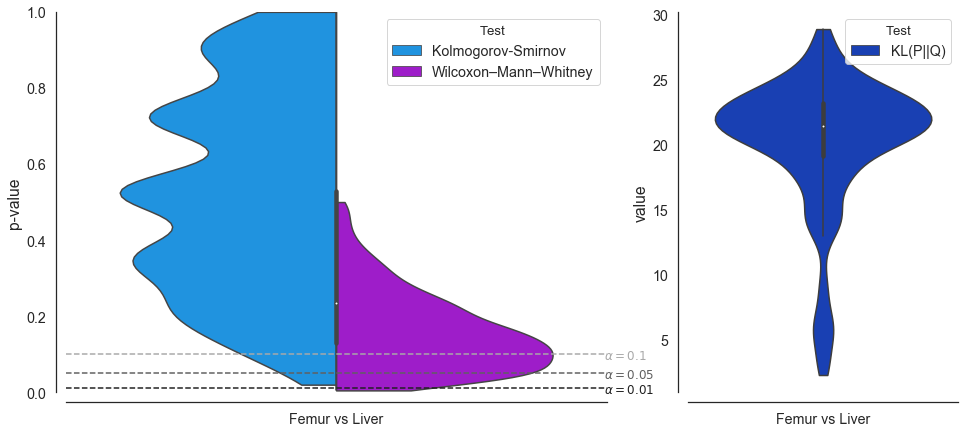


************************************************** Comm-Prog **************************************************
						 Femur vs Liver

Running 89 different sampling
	 * Minimum       p-value KS: 9.45e-01; p-value MW: 2.75e-01
	 * Maximum       p-value KS: 9.88e-01; p-value MW: 3.63e-01
	 * Average       p-value KS: 9.64e-01; p-value MW: 3.24e-01
	 * Standard dev. p-value KS: 2.09e-02; p-value MW: 2.61e-02
	 * Median        p-value KS: 9.45e-01; p-value MW: 3.28e-01

	 * Minimum       KL(P||Q): 4.25e+01
	 * Maximum       KL(P||Q): 8.17e+01
	 * Average       KL(P||Q): 5.99e+01
	 * Standard dev. KL(P||Q): 6.78e+00
	 * Median        KL(P||Q): 6.06e+01




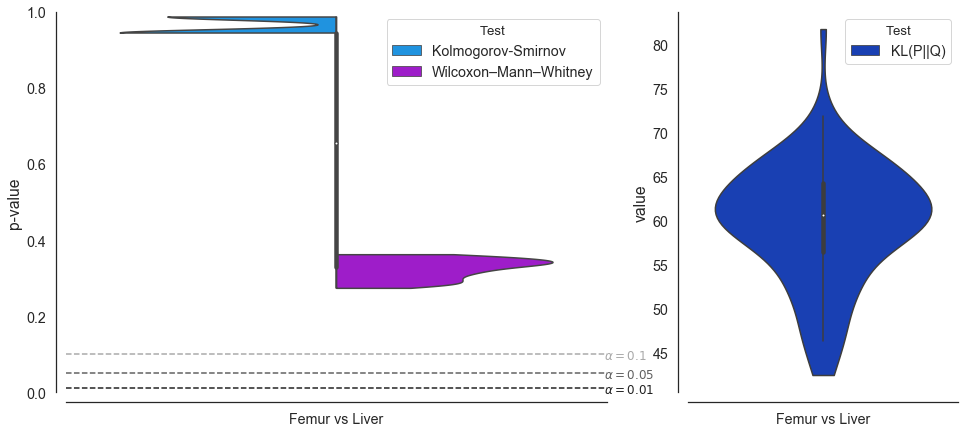


************************************************** Comm-Prog-Cycling **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.96e-03; p-value MW: 3.15e-03
	 * Maximum       p-value KS: 9.81e-01; p-value MW: 4.99e-01
	 * Average       p-value KS: 3.36e-01; p-value MW: 1.85e-01
	 * Standard dev. p-value KS: 2.54e-01; p-value MW: 1.26e-01
	 * Median        p-value KS: 2.31e-01; p-value MW: 1.58e-01

	 * Minimum       KL(P||Q): 5.21e-03
	 * Maximum       KL(P||Q): 3.36e+00
	 * Average       KL(P||Q): 2.34e+00
	 * Standard dev. KL(P||Q): 5.97e-01
	 * Median        KL(P||Q): 2.48e+00




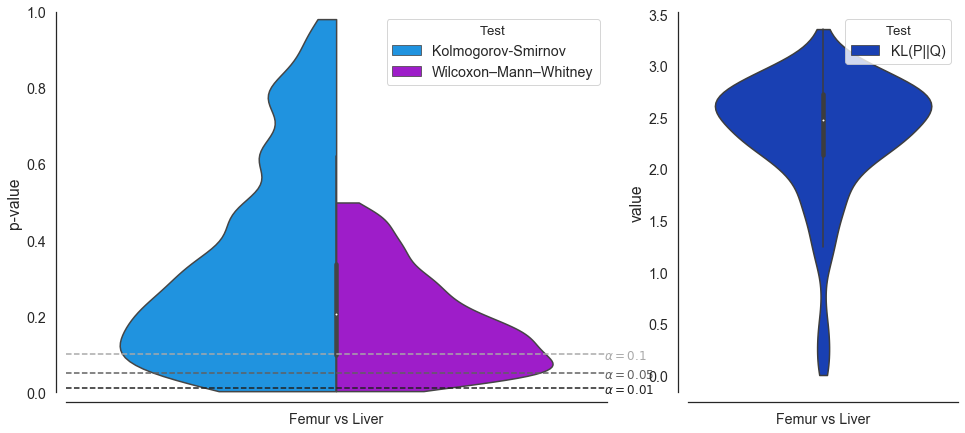


************************************************** Dend-Cell-Cycling **************************************************
						 Femur vs Liver

Running 21 different sampling
	 * Minimum       p-value KS: 8.32e-01; p-value MW: 2.99e-01
	 * Maximum       p-value KS: 8.32e-01; p-value MW: 4.95e-01
	 * Average       p-value KS: 8.32e-01; p-value MW: 3.94e-01
	 * Standard dev. p-value KS: 1.11e-16; p-value MW: 6.31e-02
	 * Median        p-value KS: 8.32e-01; p-value MW: 4.09e-01

	 * Minimum       KL(P||Q): 1.92e+00
	 * Maximum       KL(P||Q): 1.04e+01
	 * Average       KL(P||Q): 8.48e+00
	 * Standard dev. KL(P||Q): 1.88e+00
	 * Median        KL(P||Q): 8.65e+00




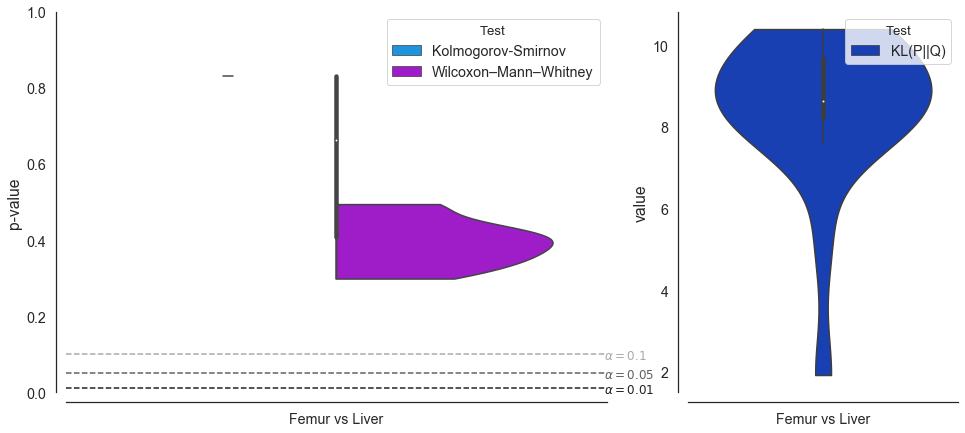


************************************************** Dendritic cells **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 1.09e-03; p-value MW: 3.07e-04
	 * Maximum       p-value KS: 5.98e-01; p-value MW: 1.79e-01
	 * Average       p-value KS: 7.97e-02; p-value MW: 2.08e-02
	 * Standard dev. p-value KS: 7.48e-02; p-value MW: 1.92e-02
	 * Median        p-value KS: 5.27e-02; p-value MW: 1.45e-02

	 * Minimum       KL(P||Q): 6.49e-03
	 * Maximum       KL(P||Q): 9.71e+00
	 * Average       KL(P||Q): 6.16e+00
	 * Standard dev. KL(P||Q): 1.94e+00
	 * Median        KL(P||Q): 6.71e+00




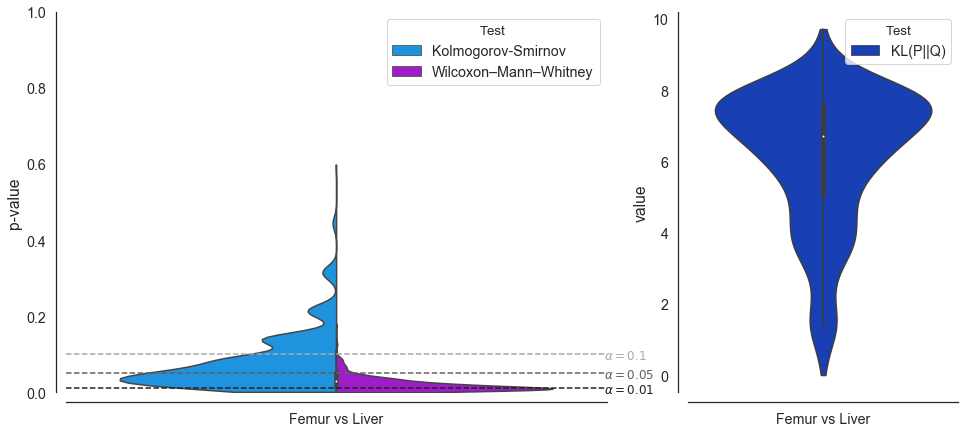


************************************************** Erythroid Prog **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 4.60e-04; p-value MW: 1.50e-03
	 * Maximum       p-value KS: 6.39e-01; p-value MW: 3.65e-01
	 * Average       p-value KS: 5.72e-02; p-value MW: 6.19e-02
	 * Standard dev. p-value KS: 6.64e-02; p-value MW: 4.66e-02
	 * Median        p-value KS: 4.24e-02; p-value MW: 5.05e-02

	 * Minimum       KL(P||Q): 5.82e+01
	 * Maximum       KL(P||Q): 1.24e+02
	 * Average       KL(P||Q): 9.84e+01
	 * Standard dev. KL(P||Q): 1.04e+01
	 * Median        KL(P||Q): 9.96e+01




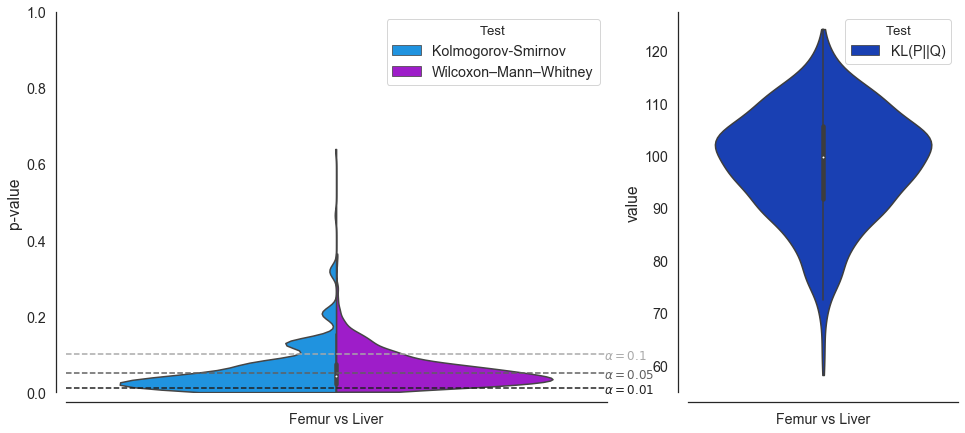


************************************************** Granulocyte Prog **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 1.26e-03; p-value MW: 4.16e-04
	 * Maximum       p-value KS: 1.00e+00; p-value MW: 5.00e-01
	 * Average       p-value KS: 4.17e-01; p-value MW: 1.57e-01
	 * Standard dev. p-value KS: 2.65e-01; p-value MW: 1.09e-01
	 * Median        p-value KS: 3.26e-01; p-value MW: 1.34e-01

	 * Minimum       KL(P||Q): 5.51e+00
	 * Maximum       KL(P||Q): 2.33e+01
	 * Average       KL(P||Q): 1.79e+01
	 * Standard dev. KL(P||Q): 2.84e+00
	 * Median        KL(P||Q): 1.83e+01




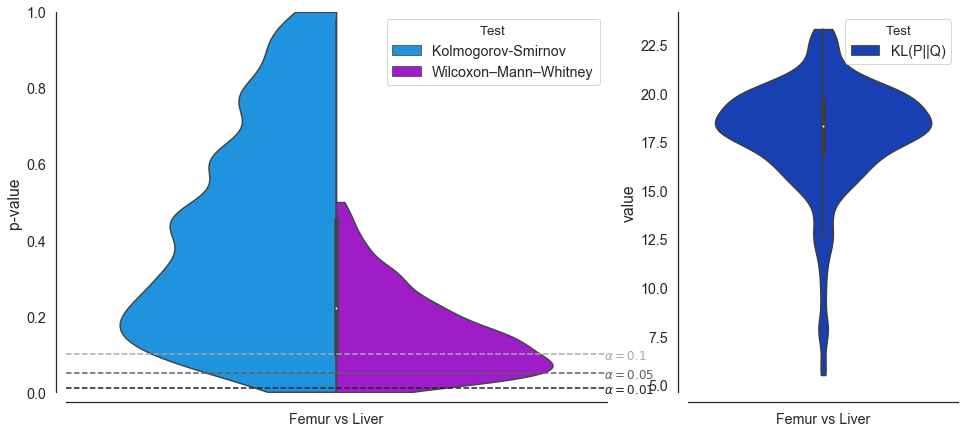


************************************************** Granulocytes 1 **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 3.52e-04; p-value MW: 1.10e-03
	 * Maximum       p-value KS: 9.36e-01; p-value MW: 2.78e-01
	 * Average       p-value KS: 9.13e-02; p-value MW: 3.20e-02
	 * Standard dev. p-value KS: 1.09e-01; p-value MW: 3.19e-02
	 * Median        p-value KS: 4.84e-02; p-value MW: 2.24e-02

	 * Minimum       KL(P||Q): 3.65e-03
	 * Maximum       KL(P||Q): 3.40e+00
	 * Average       KL(P||Q): 2.23e+00
	 * Standard dev. KL(P||Q): 4.16e-01
	 * Median        KL(P||Q): 2.29e+00




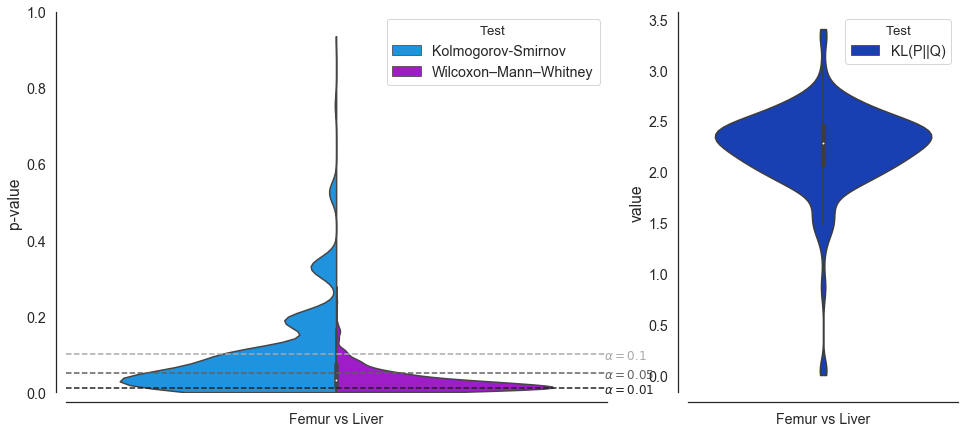


************************************************** MPP **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.12e-07; p-value MW: 2.33e-07
	 * Maximum       p-value KS: 1.55e-02; p-value MW: 1.32e-02
	 * Average       p-value KS: 7.26e-04; p-value MW: 2.54e-04
	 * Standard dev. p-value KS: 1.59e-03; p-value MW: 6.73e-04
	 * Median        p-value KS: 2.10e-04; p-value MW: 6.70e-05

	 * Minimum       KL(P||Q): 6.06e+01
	 * Maximum       KL(P||Q): 1.52e+02
	 * Average       KL(P||Q): 1.26e+02
	 * Standard dev. KL(P||Q): 9.63e+00
	 * Median        KL(P||Q): 1.27e+02




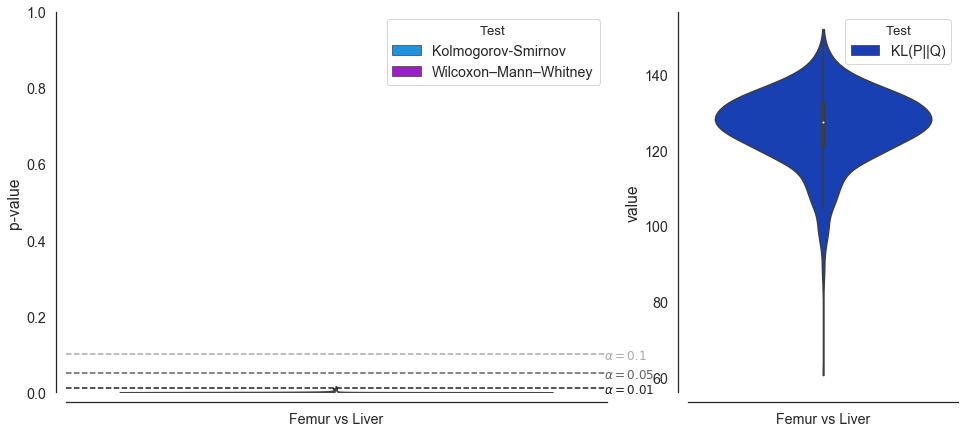


************************************************** MPP-Cycling **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 6.40e-04; p-value MW: 3.50e-04
	 * Maximum       p-value KS: 5.24e-01; p-value MW: 2.21e-01
	 * Average       p-value KS: 6.46e-02; p-value MW: 2.86e-02
	 * Standard dev. p-value KS: 6.52e-02; p-value MW: 2.58e-02
	 * Median        p-value KS: 4.97e-02; p-value MW: 2.08e-02

	 * Minimum       KL(P||Q): 2.01e-03
	 * Maximum       KL(P||Q): 3.10e-01
	 * Average       KL(P||Q): 1.56e-01
	 * Standard dev. KL(P||Q): 5.42e-02
	 * Median        KL(P||Q): 1.56e-01




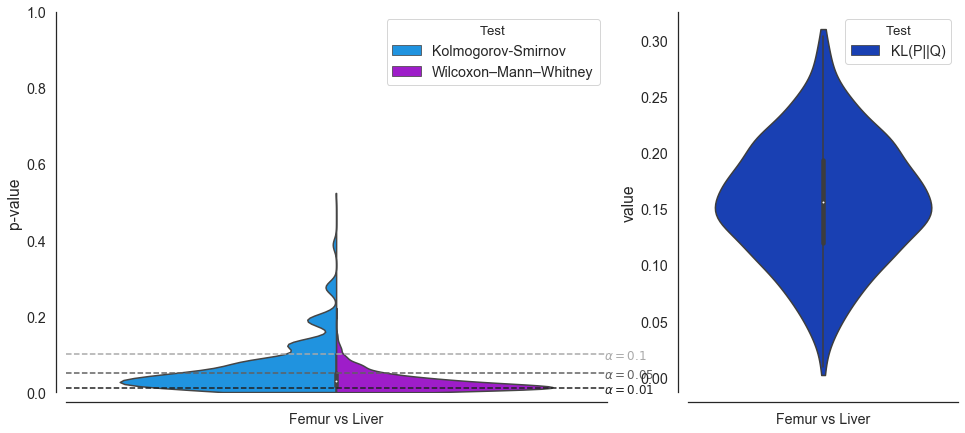


************************************************** Mast cells **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.11e-03; p-value MW: 1.01e-02
	 * Maximum       p-value KS: 9.87e-01; p-value MW: 4.98e-01
	 * Average       p-value KS: 4.98e-01; p-value MW: 2.96e-01
	 * Standard dev. p-value KS: 2.55e-01; p-value MW: 1.22e-01
	 * Median        p-value KS: 5.45e-01; p-value MW: 3.04e-01

	 * Minimum       KL(P||Q): 2.31e+01
	 * Maximum       KL(P||Q): 1.04e+02
	 * Average       KL(P||Q): 7.41e+01
	 * Standard dev. KL(P||Q): 1.36e+01
	 * Median        KL(P||Q): 7.60e+01




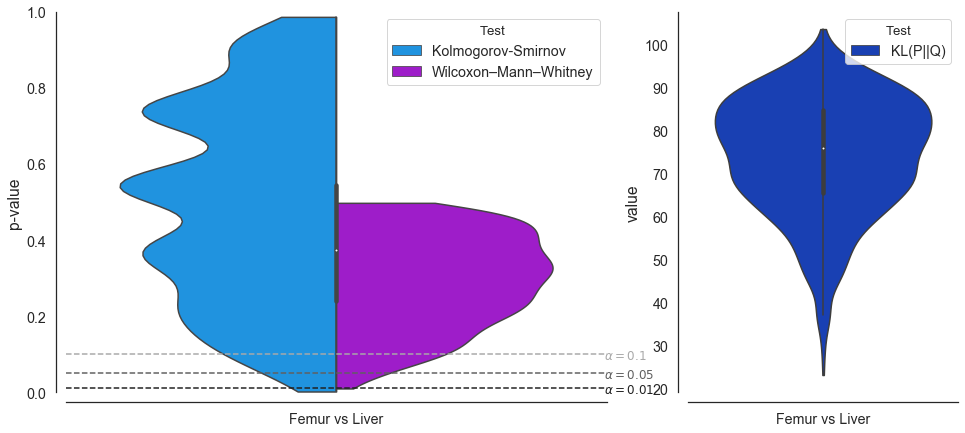


************************************************** Mat-B cells **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.04e-02; p-value MW: 3.61e-03
	 * Maximum       p-value KS: 9.38e-01; p-value MW: 5.00e-01
	 * Average       p-value KS: 3.04e-01; p-value MW: 1.57e-01
	 * Standard dev. p-value KS: 1.84e-01; p-value MW: 1.07e-01
	 * Median        p-value KS: 3.06e-01; p-value MW: 1.29e-01

	 * Minimum       KL(P||Q): 5.39e+00
	 * Maximum       KL(P||Q): 3.88e+01
	 * Average       KL(P||Q): 2.86e+01
	 * Standard dev. KL(P||Q): 6.47e+00
	 * Median        KL(P||Q): 3.06e+01




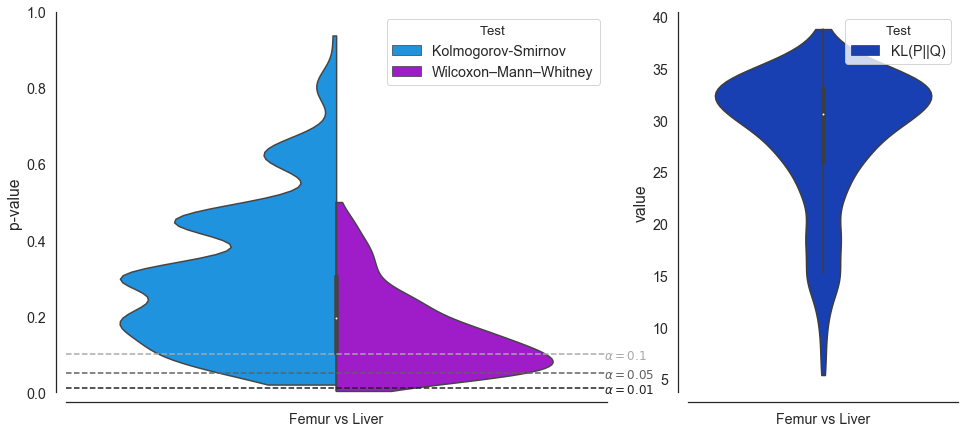


************************************************** Monocytes 1 **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 5.82e-04; p-value MW: 4.51e-04
	 * Maximum       p-value KS: 8.69e-01; p-value MW: 4.90e-01
	 * Average       p-value KS: 1.74e-01; p-value MW: 1.15e-01
	 * Standard dev. p-value KS: 1.65e-01; p-value MW: 1.06e-01
	 * Median        p-value KS: 1.12e-01; p-value MW: 8.03e-02

	 * Minimum       KL(P||Q): 1.22e+00
	 * Maximum       KL(P||Q): 1.95e+01
	 * Average       KL(P||Q): 1.25e+01
	 * Standard dev. KL(P||Q): 3.39e+00
	 * Median        KL(P||Q): 1.31e+01




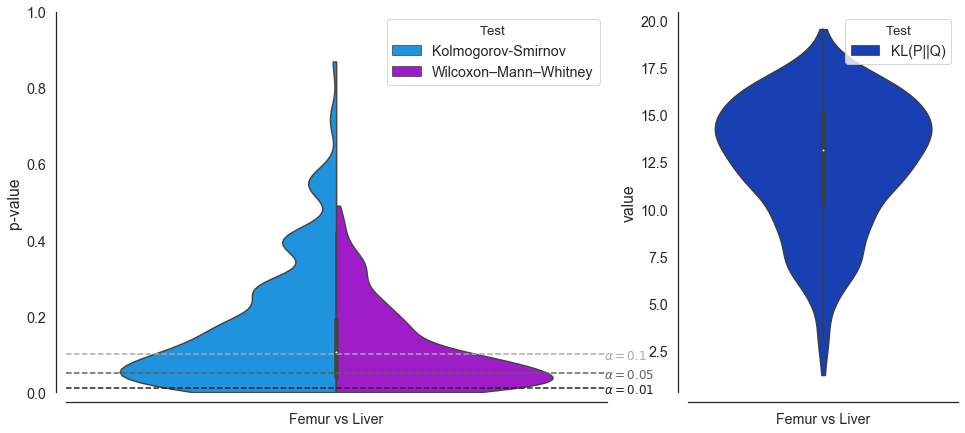


************************************************** Monocytes 2 **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 5.59e-04; p-value MW: 3.21e-04
	 * Maximum       p-value KS: 8.25e-01; p-value MW: 5.00e-01
	 * Average       p-value KS: 2.09e-01; p-value MW: 1.78e-01
	 * Standard dev. p-value KS: 1.86e-01; p-value MW: 1.37e-01
	 * Median        p-value KS: 1.36e-01; p-value MW: 1.36e-01

	 * Minimum       KL(P||Q): 4.76e-03
	 * Maximum       KL(P||Q): 2.83e+00
	 * Average       KL(P||Q): 1.64e+00
	 * Standard dev. KL(P||Q): 6.67e-01
	 * Median        KL(P||Q): 1.78e+00




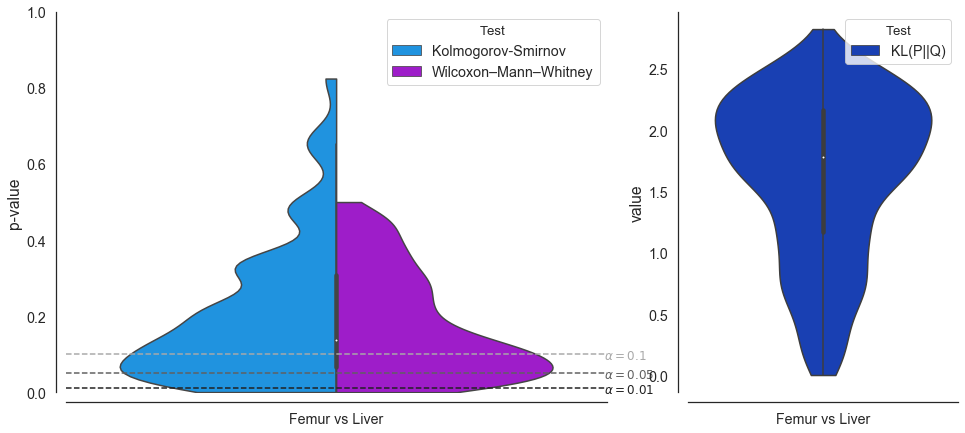


************************************************** Pre-B cells **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 1.14e-02; p-value MW: 3.19e-02
	 * Maximum       p-value KS: 9.58e-01; p-value MW: 4.99e-01
	 * Average       p-value KS: 3.29e-01; p-value MW: 3.30e-01
	 * Standard dev. p-value KS: 1.81e-01; p-value MW: 1.14e-01
	 * Median        p-value KS: 3.31e-01; p-value MW: 3.46e-01

	 * Minimum       KL(P||Q): 1.14e+01
	 * Maximum       KL(P||Q): 4.45e+01
	 * Average       KL(P||Q): 3.34e+01
	 * Standard dev. KL(P||Q): 5.57e+00
	 * Median        KL(P||Q): 3.42e+01




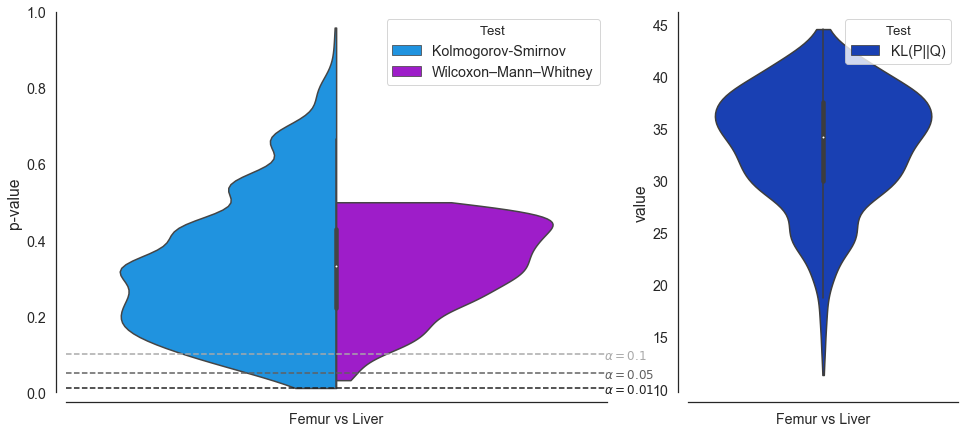


************************************************** Pro-B cells **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.56e-03; p-value MW: 3.14e-03
	 * Maximum       p-value KS: 9.94e-01; p-value MW: 4.98e-01
	 * Average       p-value KS: 3.14e-01; p-value MW: 2.96e-01
	 * Standard dev. p-value KS: 2.05e-01; p-value MW: 1.28e-01
	 * Median        p-value KS: 3.19e-01; p-value MW: 3.07e-01

	 * Minimum       KL(P||Q): 1.36e+01
	 * Maximum       KL(P||Q): 3.02e+01
	 * Average       KL(P||Q): 2.31e+01
	 * Standard dev. KL(P||Q): 2.85e+00
	 * Median        KL(P||Q): 2.33e+01




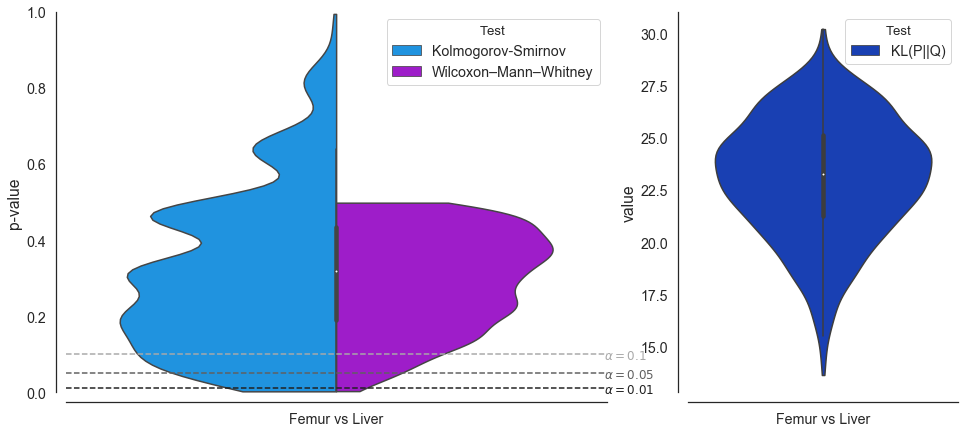


************************************************** Prog **************************************************
						 Femur vs Liver

Running 1001 different sampling
	 * Minimum       p-value KS: 2.51e-05; p-value MW: 2.12e-04
	 * Maximum       p-value KS: 2.47e-02; p-value MW: 7.36e-02
	 * Average       p-value KS: 2.64e-03; p-value MW: 1.25e-02
	 * Standard dev. p-value KS: 3.20e-03; p-value MW: 1.07e-02
	 * Median        p-value KS: 1.20e-03; p-value MW: 9.26e-03

	 * Minimum       KL(P||Q): 2.52e+01
	 * Maximum       KL(P||Q): 9.21e+01
	 * Average       KL(P||Q): 6.52e+01
	 * Standard dev. KL(P||Q): 9.16e+00
	 * Median        KL(P||Q): 6.59e+01




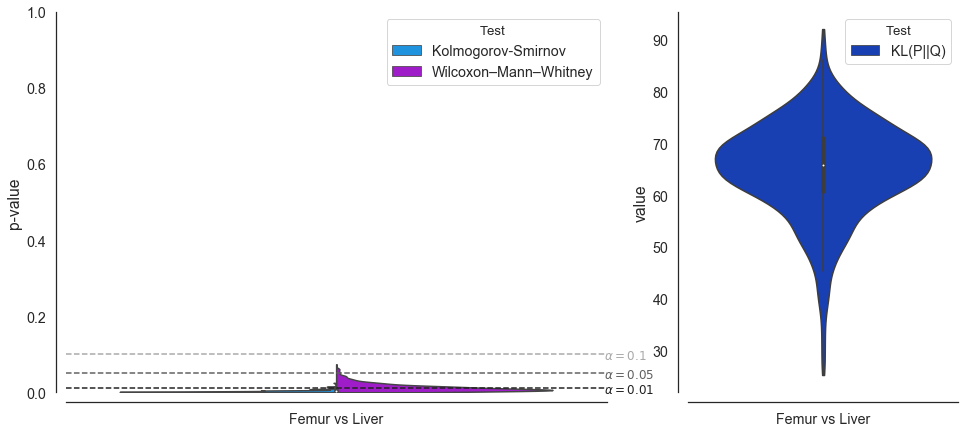

					************ Kolmogorov-Smirnov ************


group1 group2         annotation   p-value
0   Femur  Liver     CD4+ Monocytes  0.527893
1   Femur  Liver          Comm-Prog  0.945484
2   Femur  Liver  Comm-Prog-Cycling  0.231441
3   Femur  Liver  Dend-Cell-Cycling  0.831970
4   Femur  Liver    Dendritic cells  0.052669
5   Femur  Liver     Erythroid Prog  0.042409
6   Femur  Liver   Granulocyte Prog  0.325518
7   Femur  Liver     Granulocytes 1  0.048438
8   Femur  Liver                MPP  0.000210
9   Femur  Liver        MPP-Cycling  0.049664
10  Femur  Liver         Mast cells  0.545287
11  Femur  Liver        Mat-B cells  0.305629
12  Femur  Liver        Monocytes 1  0.112385
13  Femur  Liver        Monocytes 2  0.136309
14  Femur  Liver        Pre-B cells  0.331153
15  Femur  Liver        Pro-B cells  0.318829
16  Femur  Liver               Prog  0.001202

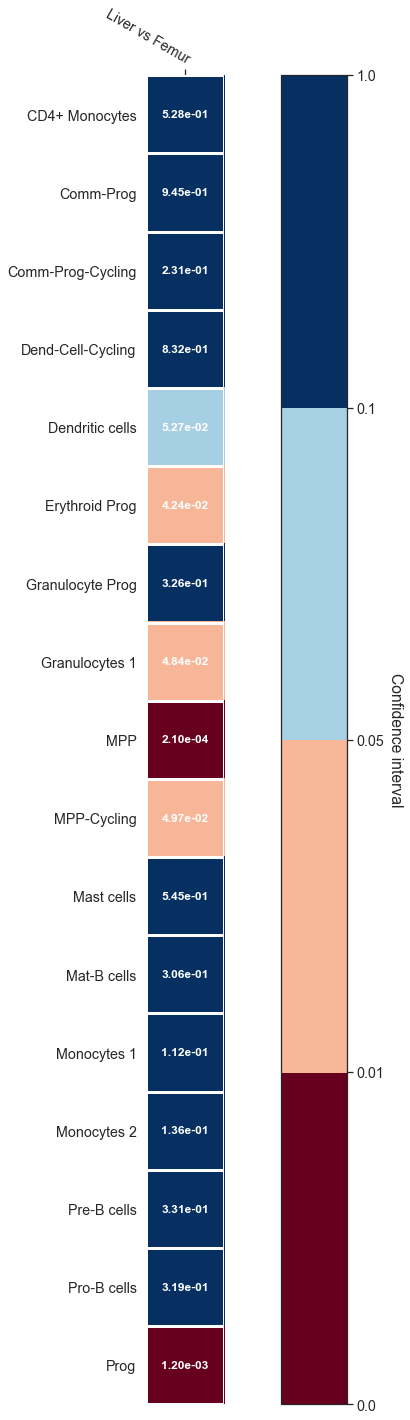

					************ Wilcoxon–Mann–Whitney ************


group1 group2         annotation   p-value
0   Femur  Liver     CD4+ Monocytes  0.137440
1   Femur  Liver          Comm-Prog  0.328050
2   Femur  Liver  Comm-Prog-Cycling  0.157735
3   Femur  Liver  Dend-Cell-Cycling  0.409075
4   Femur  Liver    Dendritic cells  0.014468
5   Femur  Liver     Erythroid Prog  0.050518
6   Femur  Liver   Granulocyte Prog  0.134373
7   Femur  Liver     Granulocytes 1  0.022386
8   Femur  Liver                MPP  0.000067
9   Femur  Liver        MPP-Cycling  0.020778
10  Femur  Liver         Mast cells  0.303542
11  Femur  Liver        Mat-B cells  0.128934
12  Femur  Liver        Monocytes 1  0.080324
13  Femur  Liver        Monocytes 2  0.136216
14  Femur  Liver        Pre-B cells  0.346278
15  Femur  Liver        Pro-B cells  0.306817
16  Femur  Liver               Prog  0.009256

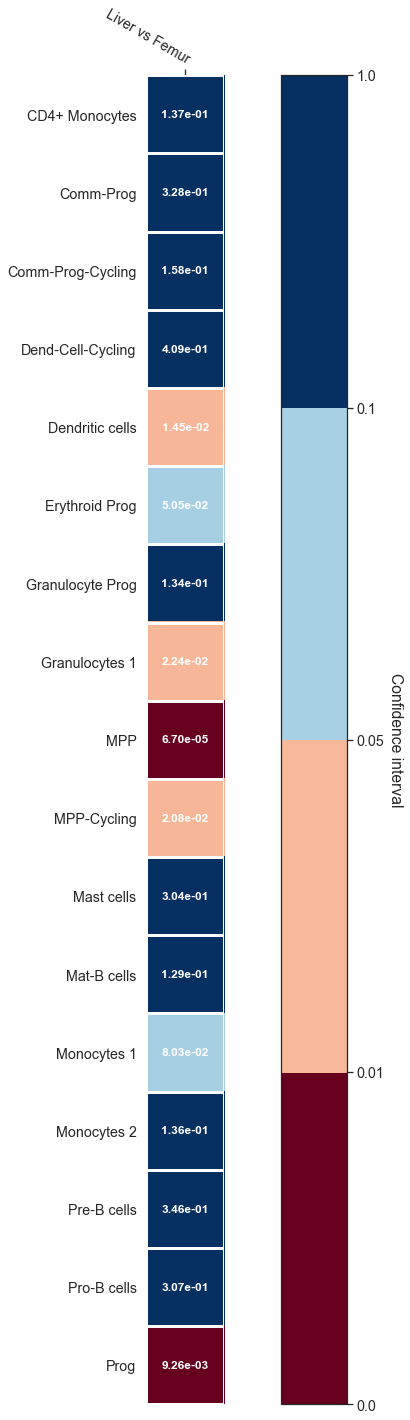

In [9]:
statisticalTests(merged,
                 group_by1="annotation",
                 group_by2="samples",
                 group_by3="origin",
                 cut_off=20,
                 n_tests=1001
                )